# Throughputs_LSSTComCam_c26202

Based on Lynne Jones code here: https://rubin-obs.slack.com/archives/C0824CTA335/p1732311332938929

Created:  2024.11.27

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc
import warnings
from IPython.display import display


# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# rubin_sim-related packages
import rubin_sim.phot_utils as pt
import syseng_throughputs as st
from rubin_sim.data import get_data_dir

# Astropy-related packages
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

# Use Rubin standardized colors/symbols/linestyles for u,g,r,i,z,y
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

/home/d/dltucker/WORK/GitHub/syseng_throughputs/syseng_throughputs/bandpassUtils.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1.2 Include user input

In [2]:
# Which repo, collection, instrument, and skymap to use.
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs
#repo = 'embargo'
#repo = '/repo/main'
repo = '/repo/dp1'

#collections = 'LSSTComCam/runs/DRP/20241101_20241113/w_2024_46/DM-47566'
#collections = 'LSSTComCam/runs/DRP/20241101_20241120/w_2024_47/DM-47746'
#collections = 'LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988'
#collections = 'LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478'
#collections = 'LSSTComCam/runs/DRP/DP1/w_2025_04/DM-48556'
#collections = 'LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666'
collections = 'LSSTComCam/DP1'

instrument = 'LSSTComCam'
skymap_name = 'lsst_cells_v1'
day_obs_start = 20241101
day_obs_end = 20241231

# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# CalSpec star name
star_name = 'C26202'

# Which CalSpec spectrum FITS file to to use?
sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'
#sedfile = '~/Downloads/c26202_mod_007.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_006.fits'
#sedfile = '~/Downloads/c26202_mod_008.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'

# RA, DEC of CalSpec star
raDeg = 53.136845833333325
decDeg = -27.86349444444444

# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

# Variables controlling output...
verbose = 3         # verbose = 0, 1, 2, 3, ...  Higher numbers mean more output.
outputCSV = False    # output CSV files
# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
post_w_2025_04 = True

### 1.3 Define useful classes and functions

In [3]:
# Cartesian x,y match with error (per Claude-3.5-Sonnet)

def cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, sep_limit=1.0, allMatches=True):
    
    import numpy as np
    from scipy.spatial import cKDTree
    import pandas as pd

    # Create KD-tree for efficient spatial searching
    tree = cKDTree(df2[[xcol2, ycol2]])

    # Find nearest neighbors within sep_limit
    separations, indices = tree.query(df1[[xcol1, ycol1]],
                                  distance_upper_bound=sep_limit)

    # Create mask for valid matches (separations less than sep_limit)
    valid_matches = separations < sep_limit

    # Create merged dataframe using only valid matches
    merged_df = pd.concat([
        df1[valid_matches].reset_index(drop=True),
        df2.iloc[indices[valid_matches]].reset_index(drop=True)
        ], axis=1)

    # If you want to keep track of the match separations
    merged_df['separation'] = separations[valid_matches]

    # If you want to keep just the best match, sort by separation 
    # and keep first occurrence of each df2 index
    if allMatches != True:
        merged_df = merged_df.sort_values('separation').drop_duplicates(
            subset=df2.columns, keep='first'
        )

    return merged_df



In [4]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

### 1.4 Instantiate the butler and registry

In [5]:
butler = dafButler.Butler(repo, collections=collections)
registry = butler.registry

## 2. Estimate expected counts for airmasses X=1.0 to 2.5

### 2.1 Build the hardware and system for ugrizy for Cerro Pachon for airmasses X=1.0-2.5 in steps of 0.1 airmass

In [6]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
#print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

system = {}
for x in airmasses:
    #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
    # using a temporary solution here:
    #atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
    atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h


### 2.2 Plot filter passbands (without the atmospheric component) and the atmospheric transmission for airmasses 1.0, 1.2, 2.0

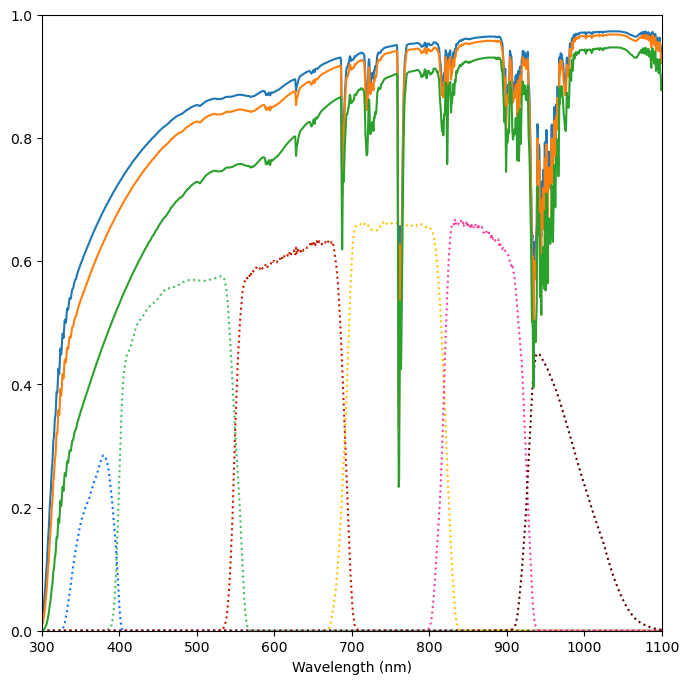

In [7]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

# Plot only if verbosity level is higher than 2...
if verbose > 2:
    
    colors = plot_filter_colors_white_background
    for f in 'ugrizy':
        plt.plot(hardware[f].wavelen, hardware[f].sb, color=colors[f], linestyle=':')
    for x in [1.0, 1.2, 2.0]:
        #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
        # using a temporary solution here:
        #atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
        atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        plt.plot(atmos.wavelen, atmos.sb, linestyle='-')
    plt.ylim(0, 1)
    plt.xlim(300, 1100)
    plt.xlabel("Wavelength (nm)")


### 2.3 Read in the CalSpec SED file and translate it into `rubin_sim` format 

In [8]:
# Read the sedfile file 
seddata = fits.getdata(sedfile)

# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

# Convert to rubin_sim format
sed = pt.Sed(wavelen=wavelen, flambda=flambda)

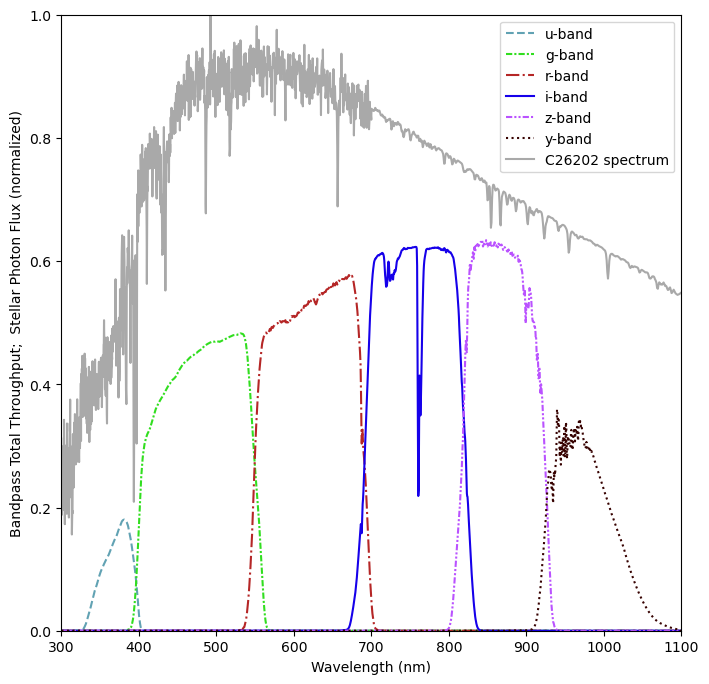

In [9]:
# Plot star spectrum (in normalized photon flux) with filter passbands

filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

x = 1.2
atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')

# Create empty list to store legend handles
legend_handles = []

for f in 'ugrizy':
    # Store the line handle when plotting
    line, = plt.plot(hardware[f].wavelen, hardware[f].sb*atmos.sb, 
                    color=filter_colors[f], 
                    linestyle=filter_linestyles[f],
                    label=f'{f}-band')  # Add label for each filter
    legend_handles.append(line)

# Constants
h = 6.626e-34  # Planck constant in J*s
c = 2.998e8    # Speed of light in m/s

# Calculate photon flux
wavelen_m = wavelen * 1e-9
flambda_joules = flambda * 1e-7
fphoton = flambda_joules * wavelen_m / (h * c)

# Store the stellar flux line handle
label = """%s spectrum""" % (star_name)
stellar_line, = plt.plot(wavelen, fphoton/max(fphoton), 
                        color='darkgrey', 
                        linestyle='-',
                        label=label)
legend_handles.append(stellar_line)

plt.xlim([300., 1100.])
plt.ylim([0.0, 1.0])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bandpass Total Throughput;  Stellar Photon Flux (normalized)")

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')

### 2.4 Define the photometric parameters to use.

In [10]:
phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)


### 2.5 Calculate the expected counts for C26202 for the given photometric parameters over the airmass range of X=1.0-2.5

First, calculate the expected counts using the standard 30-second exposure time...

In [11]:
counts = {}
for f in 'ugrizy':
    counts[f] = []
    for x in airmasses:
        counts[f].append(sed.calc_adu(system[x][f], phot_params))
    counts[f] = np.array(counts[f])


In [12]:
df_counts = pd.DataFrame(counts, index=airmasses)

if verbose > 0:
    display(df_counts)

,u,g,r,i,z,y
1.0,113907.763391,1.595912e+06,1.890468e+06,1.744184e+06,1.255182e+06,539006.696106
1.1,109280.583618,1.566476e+06,1.869171e+06,1.731674e+06,1.248109e+06,533419.304174
1.2,104812.392606,1.537426e+06,1.848023e+06,1.719315e+06,1.241126e+06,528033.612545
1.3,100595.559313,1.509313e+06,1.827390e+06,1.707302e+06,1.234321e+06,522927.462643
1.4,96528.480549,1.481603e+06,1.806920e+06,1.695422e+06,1.227598e+06,517979.615205
1.5,92610.157575,1.454307e+06,1.786605e+06,1.683676e+06,1.220949e+06,513176.303553
1.6,88907.961922,1.427875e+06,1.766786e+06,1.672205e+06,1.214450e+06,508594.033273
1.7,85277.114675,1.401413e+06,1.746836e+06,1.660723e+06,1.207942e+06,504057.078247
1.8,81827.981990,1.375680e+06,1.727280e+06,1.649446e+06,1.201556e+06,499685.722278
1.9,78679.960834,1.351503e+06,1.708712e+06,1.638680e+06,1.195429e+06,495613.318147


### 2.6 Output results to CSV file

In [13]:
if outputCSV:
    outputFile = 'LSSTComCam_C26202_expected_counts.csv'
    df_counts.to_csv(outputFile)  #  Here, we want to keep the index for the DataFrame, which, in this case, is the airmass

## 3. Query USDF Butler for ComCam exposures

### 3.1 Create query

In [14]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and range of days of observation:
query="instrument='%s' AND day_obs>=%d AND day_obs<=%d" % (instrument, day_obs_start, day_obs_end)
results = registry.queryDimensionRecords('exposure',where=query)


### 3.2 Check that there are results; stop execution if there are none

In [15]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Stop executing if there are no results returned:

n_results = results.count()

if n_results <= 0:
    raise StopExecution
else:
    print("""There are %d results returned from querying the butler for instrument %s between dates %d and %d (inclusive).""" % 
          (n_results, instrument, day_obs_start, day_obs_end))

There are 1792 results returned from querying the butler for instrument LSSTComCam between dates 20241101 and 20241231 (inclusive).


### 3.3 Instantiate a DataFrame to contain the exposure information

In [16]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension:
df_exp = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 'reason', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

### 3.4 Read the query results into the new Data Frame

In [17]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Read the query results into the new pandas `DataFrame`:

for count, info in enumerate(results):
    
    try:

        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  info.timespan.begin.utc.iso,
                                  info.timespan.end.utc.iso, 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd, info.timespan.begin.mjd]

    except:
    
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    

### 3.5 Clean up DataFrame

In [18]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:
df_exp = df_exp.astype({"id": int,'day_obs': int,'seq_num':int})

In [19]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Replace `NaN`'s in the `ra` and `dec` columns with zero.  
# (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) 
# ***(Maybe no longer necessary?)***

df_exp['ra'] = df_exp['ra'].fillna(0)
df_exp['dec'] = df_exp['dec'].fillna(0)

In [20]:
df_exp

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2024110900195,CC_O_20241109_000195,20241109,195,2024-11-10 07:20:08.667018,2024-11-10 07:20:39.112000,science,science,slew_icrs,u_02,31.044887,30.0,53.330067,-28.067394,-257.408174,265.047279,31.044887,PP-SURVEY,2.460625e+06,60624.306084
1,2024110900197,CC_O_20241109_000197,20241109,197,2024-11-10 07:21:50.236010,2024-11-10 07:22:20.672000,science,science,slew_icrs,u_02,31.541844,30.0,53.152550,-28.163257,-257.409057,264.641424,31.541844,PP-SURVEY,2.460625e+06,60624.307260
2,2024110900198,CC_O_20241109_000198,20241109,198,2024-11-10 07:25:02.990990,2024-11-10 07:25:33.432000,science,science,slew_icrs,u_02,32.378389,30.0,53.024388,-28.012638,-257.408769,264.570002,32.378389,PP-SURVEY,2.460625e+06,60624.309491
3,2024110900199,CC_O_20241109_000199,20241109,199,2024-11-10 07:25:56.606994,2024-11-10 07:26:27.047000,science,science,slew_icrs,u_02,32.649004,30.0,52.912307,-28.093945,-257.408483,264.298063,32.649004,PP-SURVEY,2.460625e+06,60624.310111
4,2024110900200,CC_O_20241109_000200,20241109,200,2024-11-10 07:26:47.058017,2024-11-10 07:27:17.489000,science,science,slew_icrs,u_02,32.706860,30.0,53.077201,-28.012074,-257.407690,264.427985,32.706860,PP-SURVEY,2.460625e+06,60624.310695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,2024112500292,CC_O_20241125_000292,20241125,292,2024-11-26 05:46:47.080986,2024-11-26 05:47:17.512000,science,science,EDFS_comcam,y_04,25.006709,30.0,58.899139,-48.610235,67.736039,216.747928,25.006709,BLOCK-320,2.460641e+06,60640.241251
1788,2024112500293,CC_O_20241125_000293,20241125,293,2024-11-26 05:47:41.428991,2024-11-26 05:48:11.873000,science,science,EDFS_comcam,y_04,25.219236,30.0,58.877885,-48.744595,67.576416,216.742670,25.219236,BLOCK-320,2.460641e+06,60640.241880
1789,2024112500294,CC_O_20241125_000294,20241125,294,2024-11-26 05:48:33.327000,2024-11-26 05:49:03.755000,science,science,EDFS_comcam,y_04,25.452435,30.0,58.829268,-48.898670,67.445975,216.715429,25.452435,BLOCK-320,2.460641e+06,60640.242481
1790,2024112500295,CC_O_20241125_000295,20241125,295,2024-11-26 05:49:28.167982,2024-11-26 05:49:58.599000,science,science,EDFS_comcam,y_04,25.397093,30.0,59.186950,-48.915320,66.674625,216.561916,25.397093,BLOCK-320,2.460641e+06,60640.243115


### 3.6 Add airmass to DataFrame

In [21]:
# Add an airmass to df_exp...

df_exp['airmass'] = np.round(1./np.cos(np.deg2rad(df_exp['zenith_angle'])), decimals=3)

In [22]:
# Printout zenith angle and airmass if verbosity level is greater than 1...
if verbose > 1:
    display(df_exp[['zenith_angle','airmass']])

,zenith_angle,airmass
0,31.044887,1.167
1,31.541844,1.173
2,32.378389,1.184
3,32.649004,1.188
4,32.706860,1.188
...,...,...
1787,25.006709,1.103
1788,25.219236,1.105
1789,25.452435,1.107
1790,25.397093,1.107


### 3.7 Extract just "science" exposures

In [23]:
# Create a `DataFrame` containing just the science exposures:
df_sci = df_exp[df_exp.type == 'science']

In [24]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
0,2024110900195,31.044887,1.167
1,2024110900197,31.541844,1.173
2,2024110900198,32.378389,1.184
3,2024110900199,32.649004,1.188
4,2024110900200,32.706860,1.188
...,...,...,...
1787,2024112500292,25.006709,1.103
1788,2024112500293,25.219236,1.105
1789,2024112500294,25.452435,1.107
1790,2024112500295,25.397093,1.107


### 3.8 Remove any exposures in the "bad visit" list

#### 3.8.1 Read in "bad visit" list

In [25]:
df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
#df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)

# Look at bad visits table, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_bad_visits)

,exposure,comment
0,2024110500234,i donuts
1,2024110500236,i donuts
2,2024110500237,i donuts
3,2024110500240,i donuts
4,2024110500241,i donuts
...,...,...
153,2024120900448,g donuts
154,2024120900449,g donuts
155,2024120900450,g donuts
156,2024120900451,g donuts + slew during exposure


#### 3.8.2 Remove from df_sci and exposures found in df_bad_visits

In [26]:
df_sci = df_sci[~df_sci['id'].isin(df_bad_visits['exposure'])]


In [27]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
0,2024110900195,31.044887,1.167
1,2024110900197,31.541844,1.173
2,2024110900198,32.378389,1.184
3,2024110900199,32.649004,1.188
4,2024110900200,32.706860,1.188
...,...,...,...
1787,2024112500292,25.006709,1.103
1788,2024112500293,25.219236,1.105
1789,2024112500294,25.452435,1.107
1790,2024112500295,25.397093,1.107


### 3.9 Save results as a CSV file

In [28]:
if outputCSV:
    outputFile = """LSSTComCam_visits_%d-%d.csv""" % (day_obs_start, day_obs_end)
    df_sci.to_csv(outputFile, index=False)

### 3.10 Create a Pandas DataFrame from df_sci that just contains the visit id, exposure time, zenith angle, and airmass

In [29]:
df_sci_airmass = df_sci[['id', 'expos', 'zenith_angle','airmass']].copy(deep=True)
df_sci_airmass.reset_index(drop=True, inplace=True)

# Look at pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci_airmass)

,id,expos,zenith_angle,airmass
0,2024110900195,30.0,31.044887,1.167
1,2024110900197,30.0,31.541844,1.173
2,2024110900198,30.0,32.378389,1.184
3,2024110900199,30.0,32.649004,1.188
4,2024110900200,30.0,32.706860,1.188
...,...,...,...,...
1787,2024112500292,30.0,25.006709,1.103
1788,2024112500293,30.0,25.219236,1.105
1789,2024112500294,30.0,25.452435,1.107
1790,2024112500295,30.0,25.397093,1.107


## 4. Query USDF Butler for ComCam measurements of C26202

### 4.1 Find the `dataId`'s for all `visit_image`'s in this repo/collection that overlap the sky position of C26202:

In [30]:
datasetRefs = butler.query_datasets("visit_image", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

# Look datasetRefs, but only if verbosity level is greater than 1:
if verbose > 1:
    for i, ref in enumerate(datasetRefs):    
        print(i, ref.dataId)

print(f"\nFound {len(datasetRefs)} visit_images")

0 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100074, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
1 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100075, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
2 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100087, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
3 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100088, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
4 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100093, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
5 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100094, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
6 {instrument: 'LSSTComCam', detector: 0, visit: 2024111600115, band: 'r', day_obs: 20241116, physical_filter: 'r_03'}
7 {instrument: 'LSSTComCam', detector: 0, visit: 2024111700126, band: 'r', day_obs: 20241117, physical_filter: 'r_03'}
8 {instrument: 'LSSTComCam', detector: 0, visit:

### 4.2 Create a pandas Dataframe containing the `recalibrated_star_detector` (formerly `sourceTable`) info for all these `(preliminary_)visit_image`'s

#### 4.2.1 Loop over the `datasetRefs` again, grabbing the contents of the `recalibrated_star_detector` table for each `ref` and combining into all into one big pandas DataFrame.  

In [31]:
src_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('recalibrated_star_detector', dataId=dataId)
    src_list.append(src.to_pandas())

    if ((verbose >= 2) | (i < 10)): 
        print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(src)} sources.")
    if ((verbose < 2) & (i == 10)): 
        print("...")

src_all = pd.concat(src_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(src_all)} sources.")


0 Visit 2024111100074, Detector 0:  Retrieved catalog of 1342 sources.
1 Visit 2024111100075, Detector 0:  Retrieved catalog of 1008 sources.
2 Visit 2024111100087, Detector 0:  Retrieved catalog of 1281 sources.
3 Visit 2024111100088, Detector 0:  Retrieved catalog of 1746 sources.
4 Visit 2024111100093, Detector 0:  Retrieved catalog of 1591 sources.
5 Visit 2024111100094, Detector 0:  Retrieved catalog of 1264 sources.
6 Visit 2024111600115, Detector 0:  Retrieved catalog of 1278 sources.
7 Visit 2024111700126, Detector 0:  Retrieved catalog of 2085 sources.
8 Visit 2024111700127, Detector 0:  Retrieved catalog of 2084 sources.
9 Visit 2024111700128, Detector 0:  Retrieved catalog of 2153 sources.
10 Visit 2024111700129, Detector 0:  Retrieved catalog of 2058 sources.
11 Visit 2024111700131, Detector 0:  Retrieved catalog of 1923 sources.
12 Visit 2024111700134, Detector 0:  Retrieved catalog of 2086 sources.
13 Visit 2024111700144, Detector 0:  Retrieved catalog of 1347 sources.
14

In [32]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 1:
if verbose > 1:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter,sourceId
0,53.220300,-27.785943,0,1560.974703,36.114699,0.412613,0.517266,53.220300,-27.785943,2.512271e-05,...,False,False,False,False,True,2024111100074,0,i,i_06,600333358697807883
1,53.205080,-27.743406,0,759.765664,48.847196,0.415665,0.380847,53.205080,-27.743406,1.893837e-05,...,False,False,False,False,True,2024111100074,0,i,i_06,600333358697807885
2,53.255029,-27.891504,0,3535.787592,51.917386,0.553007,0.750263,53.255029,-27.891504,3.624042e-05,...,False,False,False,False,True,2024111100074,0,i,i_06,600333358697807886
3,53.199706,-27.727185,0,456.216803,47.199150,1.695176,1.461114,53.199706,-27.727185,7.313039e-05,...,False,False,False,False,True,2024111100074,0,i,i_06,600333358697807887
4,53.204113,-27.741506,0,722.660267,53.772882,0.520267,0.959846,53.204113,-27.741506,4.597102e-05,...,False,False,False,False,True,2024111100074,0,i,i_06,600333358697807888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306499,53.336908,-27.798806,600460949295464694,2695.037048,3771.236710,0.180536,0.169550,53.336908,-27.798806,8.365624e-06,...,False,False,False,False,True,2024121000426,8,r,r_03,600460949295464847
1306500,53.359288,-27.906192,600460949295464705,734.049210,3829.435197,0.384833,0.423529,53.359288,-27.906192,2.080320e-05,...,False,False,False,False,True,2024121000426,8,r,r_03,600460949295464849
1306501,53.360616,-27.906337,600460949295464705,728.252254,3849.860690,0.011837,0.011507,53.360616,-27.906337,5.667389e-07,...,False,False,False,False,True,2024121000426,8,r,r_03,600460949295464850
1306502,53.340347,-27.760932,600460949295464711,3359.110500,3928.482985,3.073642,2.762305,53.340347,-27.760932,1.365089e-04,...,False,False,False,False,True,2024121000426,8,r,r_03,600460949295464851


#### 4.2.2 Add exposure time, zenith distance, and airmass to src_all

In [33]:
src_all_tmp = pd.merge(src_all, df_sci_airmass, left_on='visit', right_on='id')
src_all_tmp.drop('id', axis=1, inplace=True)
# Remove any rows for which airmass is a NaN
src_all_tmp.dropna(subset=['airmass'], inplace=True)
src_all = src_all_tmp

# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,sky_source,detect_isPrimary,visit,detector,band,physical_filter,sourceId,expos,zenith_angle,airmass
0,53.220300,-27.785943,0,1560.974703,36.114699,0.412613,0.517266,53.220300,-27.785943,2.512271e-05,...,False,True,2024111100074,0,i,i_06,600333358697807883,30.0,44.474111,1.401
1,53.205080,-27.743406,0,759.765664,48.847196,0.415665,0.380847,53.205080,-27.743406,1.893837e-05,...,False,True,2024111100074,0,i,i_06,600333358697807885,30.0,44.474111,1.401
2,53.255029,-27.891504,0,3535.787592,51.917386,0.553007,0.750263,53.255029,-27.891504,3.624042e-05,...,False,True,2024111100074,0,i,i_06,600333358697807886,30.0,44.474111,1.401
3,53.199706,-27.727185,0,456.216803,47.199150,1.695176,1.461114,53.199706,-27.727185,7.313039e-05,...,False,True,2024111100074,0,i,i_06,600333358697807887,30.0,44.474111,1.401
4,53.204113,-27.741506,0,722.660267,53.772882,0.520267,0.959846,53.204113,-27.741506,4.597102e-05,...,False,True,2024111100074,0,i,i_06,600333358697807888,30.0,44.474111,1.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306499,53.336908,-27.798806,600460949295464694,2695.037048,3771.236710,0.180536,0.169550,53.336908,-27.798806,8.365624e-06,...,False,True,2024121000426,8,r,r_03,600460949295464847,30.0,38.999464,1.287
1306500,53.359288,-27.906192,600460949295464705,734.049210,3829.435197,0.384833,0.423529,53.359288,-27.906192,2.080320e-05,...,False,True,2024121000426,8,r,r_03,600460949295464849,30.0,38.999464,1.287
1306501,53.360616,-27.906337,600460949295464705,728.252254,3849.860690,0.011837,0.011507,53.360616,-27.906337,5.667389e-07,...,False,True,2024121000426,8,r,r_03,600460949295464850,30.0,38.999464,1.287
1306502,53.340347,-27.760932,600460949295464711,3359.110500,3928.482985,3.073642,2.762305,53.340347,-27.760932,1.365089e-04,...,False,True,2024121000426,8,r,r_03,600460949295464851,30.0,38.999464,1.287


In [34]:
for col in src_all.columns:
    print(col)

coord_ra
coord_dec
parentSourceId
x
y
xErr
yErr
ra
dec
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
sizeExtendedness
blendedness_abs
localPhotoCalib
localPhotoCalib_flag
localPhotoCalibErr
localWcs_flag
localWcs_CDMatrix_2_1
localWcs_CDMatrix_1_1
localWcs_CDMatrix_1_2
localWcs_CDMatrix_2_2
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux


#### 4.2.3 Save `src_all` as a CSV file

In [35]:
if outputCSV:
    src_all.to_csv('LSSTComCam_C26202_fields.sourceTable.csv', index=False)

### 4.3 Create a pandas Dataframe containing the `icSrc` table info for all these `calexp`'s

#### 4.3.1 Loop over the `datasetRefs` again, grabbing the contents of the `icSrc` table for each `ref` and combining them into all into one big pandas DataFrame.  

In [36]:
icSrc_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    try:
        dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}

        # There was a major change in the DRP pipeline starting with w_2025_05.
        # See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
        if post_w_2025_04:
            #icSrc = butler.get('initial_psf_stars_detector', dataId=dataId)
            icSrc = butler.get('single_visit_psf_star', dataId=dataId)
            icSrc_table = icSrc
        else:
            icSrc = butler.get('icSrc', dataId=dataId)
            icSrc_table = icSrc.asAstropy()
            
        df_icSrc = icSrc_table.to_pandas()
        icSrc_list.append(df_icSrc)

        # Look at visit/detector info, but only if verbosity level is greater than 1:
        if verbose > 1:
            print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(icSrc_table)} sources.")

    except Exception as e:
        print(f"Unexpected error: {e}")

icSrc_all = pd.concat(icSrc_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(icSrc_all)} sources.")


0 Visit 2024111100074, Detector 0:  Retrieved catalog of 167 sources.
1 Visit 2024111100075, Detector 0:  Retrieved catalog of 129 sources.
2 Visit 2024111100087, Detector 0:  Retrieved catalog of 153 sources.
3 Visit 2024111100088, Detector 0:  Retrieved catalog of 203 sources.
4 Visit 2024111100093, Detector 0:  Retrieved catalog of 216 sources.
5 Visit 2024111100094, Detector 0:  Retrieved catalog of 177 sources.
6 Visit 2024111600115, Detector 0:  Retrieved catalog of 154 sources.
7 Visit 2024111700126, Detector 0:  Retrieved catalog of 214 sources.
8 Visit 2024111700127, Detector 0:  Retrieved catalog of 196 sources.
9 Visit 2024111700128, Detector 0:  Retrieved catalog of 233 sources.
10 Visit 2024111700129, Detector 0:  Retrieved catalog of 204 sources.
11 Visit 2024111700131, Detector 0:  Retrieved catalog of 206 sources.
12 Visit 2024111700134, Detector 0:  Retrieved catalog of 211 sources.
13 Visit 2024111700144, Detector 0:  Retrieved catalog of 214 sources.
14 Visit 2024111

In [37]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(icSrc_all)

,id,coord_ra,coord_dec,parent,coord_raErr,coord_decErr,coord_ra_dec_Cov,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,...,base_NormalizedCompensatedTophatFlux_instFlux,slot_CalibFlux_instFlux,base_NormalizedCompensatedTophatFlux_instFluxErr,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used
0,600333358697808022,0.928409,-0.483508,0,NaN,NaN,NaN,13.000000,13.000000,10.000000,...,NaN,NaN,NaN,NaN,True,True,False,False,False,False
1,600333358697808023,0.928830,-0.484749,0,NaN,NaN,NaN,1346.000000,1346.000000,9.000000,...,NaN,NaN,NaN,NaN,True,True,False,False,False,False
2,600333358697808024,0.929613,-0.487096,0,1.788354e-07,1.612428e-07,4.379121e-15,3865.325102,3865.325102,19.935209,...,NaN,NaN,NaN,NaN,True,True,False,False,False,False
3,600333358697808025,0.928912,-0.485008,0,2.644150e-08,3.265267e-08,-4.944009e-17,1623.438759,1623.438759,13.758505,...,NaN,NaN,NaN,NaN,True,True,False,False,False,False
4,600333358697808026,0.929208,-0.486091,0,6.465232e-08,5.255231e-08,7.570157e-16,2768.358073,2768.358073,75.488788,...,184212.259530,184212.259530,1852.710196,1852.710196,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137108,600460949295464540,0.930905,-0.485181,0,1.472558e-07,1.762042e-07,-4.317097e-16,2695.045162,2695.045162,3771.238192,...,174356.490957,174356.490957,3215.336235,3215.336235,False,False,False,False,False,False
137109,600460949295464541,0.931200,-0.486658,0,7.748623e-08,8.250183e-08,1.286639e-16,1151.611591,1151.611591,3806.115005,...,73813.181601,73813.181601,3129.277351,3129.277351,False,False,False,False,False,False
137110,600460949295464542,0.931318,-0.487058,0,9.817693e-09,1.141205e-08,-8.560678e-19,728.252372,728.252372,3849.860755,...,598885.433710,598885.433710,3214.066714,3214.066714,False,False,False,True,True,True
137111,600460949295464543,0.931467,-0.487310,0,2.357153e-07,2.247655e-07,2.926197e-15,450.852784,450.852784,3944.367044,...,104600.691468,104600.691468,3111.748895,3111.748895,False,False,False,False,False,False


In [38]:
#for col in icSrc_all.columns:
#    print(col,)

#### 4.3.2 Save `icSrc_all` as a CSV file

In [39]:
if outputCSV:
    icSrc_all.to_csv('LSSTComCam_C26202_fields_icSrc.csv', index=False)

## 5 Calculate psf to total flux aperture magnitudes on a per-visit basis

### 5.1 Match src_all and icSrc_all catalogs

In [40]:
# We will perform the match using the cartesianXYMatchWithError function defined above.

df1 = src_all.copy(deep=True)
xcol1 = 'x'
ycol1 = 'y'

df2 = icSrc_all.copy(deep=True)
xcol2 = 'base_SdssCentroid_x'
ycol2 = 'base_SdssCentroid_y'

sep_limit = 1.0

df_match = cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, 1.0, False)

# Print number of matches
print(f"Number of matches found: {len(df_match)}")

# Print statistics of match distances
print("\nMatch distance statistics:")
print(df_match['separation'].describe())

Number of matches found: 182738

Match distance statistics:
count    182738.000000
mean          0.117558
std           0.266043
min           0.000000
25%           0.000007
50%           0.000056
75%           0.011034
max           0.999981
Name: separation, dtype: float64


In [41]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_match)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,slot_CalibFlux_instFlux,base_NormalizedCompensatedTophatFlux_instFluxErr,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation
126605,53.090536,-27.828378,0,2631.000000,1369.000000,NaN,NaN,53.090536,-27.828378,NaN,...,7.340439e+06,4482.808363,4482.808363,False,False,False,False,False,False,0.000000
68476,53.148897,-27.788903,0,1446.000000,1013.000000,NaN,NaN,53.148897,-27.788903,NaN,...,2.672683e+06,1859.978357,1859.978357,False,False,False,False,False,False,0.000000
116755,53.042599,-27.803679,0,3919.000000,2254.000000,NaN,NaN,53.042599,-27.803679,NaN,...,1.558151e+05,2594.072135,2594.072135,False,False,False,False,False,False,0.000000
4104,53.096592,-27.902283,0,3452.000000,2377.000000,NaN,NaN,53.096592,-27.902283,NaN,...,4.493007e+04,885.295747,885.295747,False,False,False,False,False,False,0.000000
44597,53.103972,-27.788621,0,3045.000000,388.000000,NaN,NaN,53.103972,-27.788621,NaN,...,2.782603e+06,1993.895571,1993.895571,False,False,False,False,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177458,53.212694,-27.898303,0,793.692301,3733.044754,0.340190,0.333675,53.212694,-27.898303,0.000016,...,3.114999e+04,1312.267687,1312.267687,False,False,False,False,False,False,0.999889
37047,53.028556,-27.745948,0,3405.000000,1057.000000,NaN,NaN,53.028556,-27.745948,NaN,...,5.153407e+04,1701.317562,1701.317562,False,False,False,False,False,True,0.999933
29527,53.250230,-27.763676,0,2800.322919,3889.496209,0.648401,1.082389,53.250230,-27.763676,0.000052,...,5.517138e+05,1419.523133,1419.523133,False,False,False,True,True,True,0.999941
50642,53.289808,-27.762896,600452147562152818,3058.080526,2567.651415,0.430730,0.681286,53.289808,-27.762896,0.000027,...,5.657032e+04,2294.288456,2294.288456,False,False,False,False,False,False,0.999968


### 5.2 Create dataframe containing the visit-by-visit median psf-to-total flux aperture corrections.

In [42]:
# Create a column containing the psf-to-total flux aperture correction for each individual source.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    #  We will use 'base_PsfFlux_instFlux' as our primary instrumental flux measurement.
    #  We will take 1.04*'base_CircularApertureFlux_12_0_instFlux' as the total flux.
    df_match['apCorrTot'] = 1.04*df_match['base_CircularApertureFlux_12_0_instFlux'] / df_match['base_PsfFlux_instFlux']
else:
    #  We will use 'base_PsfFlux_instFlux' as our primary instrumental flux measurement.
    #  We will take 'base_CircularApertureFlux_70_0_instFlux' as the total flux.
    df_match['apCorrTot'] = df_match['base_CircularApertureFlux_70_0_instFlux'] / df_match['base_PsfFlux_instFlux']


# Create a mask to cull sources with "bad" measurements.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_12_0_flag) & \
            (~df_match.base_PsfFlux_flag)  
else:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_70_0_flag) & \
            (~df_match.base_PsfFlux_flag)  

# Create an another mask to cull sources that are too faint or (possibly) too bright.
psfFlux_min = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.75)
psfFlux_max = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.95)
mask = mask1 & (df_match.base_PsfFlux_instFlux >= psfFlux_min) & (df_match.base_PsfFlux_instFlux < psfFlux_max)

# Calculate median ratio per visit, ignoring NaNs
median_apCorrTots = df_match[mask].groupby('visit')['apCorrTot'].agg(lambda x: np.nanmedian(x))

# Create a pandas DataFrame out of this pandas Series
df_median_apCorrTots = median_apCorrTots.reset_index()

# Rename `apCorrTot` to `apCorrTot_median` in df_median_apCorrTots
df_median_apCorrTots.rename(columns={'apCorrTot': 'apCorrTot_median'}, inplace=True)

## Remove the original apCorrTot column from df_match
#df_match.drop('apCorrTot', axis=1, inplace=True)

# Show the dataframe of median apCorrTots by visit id, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_median_apCorrTots)

,visit,apCorrTot_median
0,2024110800245,1.023066
1,2024110800246,1.023765
2,2024110800247,1.025619
3,2024110800248,1.029030
4,2024110800249,1.023908
...,...,...
705,2024121000428,1.006865
706,2024121000430,0.999301
707,2024121000432,1.006528
708,2024121000433,0.995414


### 5.3 Add the visit-by-visit median aperture corrections to the `df_match` (combined `src_all`+`icSrc_all`) pandas DataFrame

In [43]:
df_match = df_match.merge(df_median_apCorrTots, on='visit')

In [44]:
# Display result sorted in ascending order of visit (primarily) and RA (secondarily), 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_match.sort_values(by=['visit', 'ra']))

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation,apCorrTot,apCorrTot_median
30301,52.917599,-28.036761,0,187.065762,38.440917,0.009123,0.009786,52.917599,-28.036761,4.795186e-07,...,1133.344028,False,False,False,True,True,True,0.000004,1.026032,1.023066
43557,52.929804,-28.007618,0,741.057171,108.270946,0.011966,0.013058,52.929804,-28.007618,6.394527e-07,...,1098.641809,False,False,False,True,True,True,0.000006,1.046902,1.023066
95524,52.931296,-27.993942,0,985.867575,75.691982,0.123193,0.091356,52.931296,-27.993942,4.585786e-06,...,1070.934828,False,False,False,False,False,False,0.000073,1.963570,1.023066
31846,52.933716,-28.003400,0,828.949463,151.517952,0.022421,0.023546,52.933716,-28.003400,1.155012e-06,...,1063.950831,False,False,False,False,False,True,0.000004,1.016504,1.023066
175927,52.936859,-27.962347,0,1559.003531,33.167611,0.266435,0.200303,52.936859,-27.962347,1.004522e-05,...,1272.947186,False,False,False,False,False,True,0.878404,1.003295,1.023066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142946,53.261478,-27.721217,0,3658.517268,3218.310887,0.152961,0.151431,53.261478,-27.721217,7.473845e-06,...,1444.000554,False,False,False,False,False,False,0.026148,1.429228,0.991062
32813,53.262341,-27.747265,0,3247.111079,3441.682005,0.028911,0.028631,53.262341,-27.747265,1.412588e-06,...,1444.876371,False,False,False,False,False,True,0.000004,0.981374,0.991062
105254,53.280505,-27.742443,0,3454.824024,3660.441657,0.225901,0.250567,53.280505,-27.742443,1.210162e-05,...,1420.950947,False,False,False,False,False,False,0.000151,1.497655,0.991062
148369,53.289593,-27.735301,0,3634.560704,3731.569830,0.390170,0.334641,53.289593,-27.735301,1.707265e-05,...,1400.995805,False,False,False,False,False,False,0.064929,1.394264,0.991062


## 6. Extract the rows containing C26202 from the matched src_all and icSrc_all catalogs

In [45]:
# Based on code retrieved from Claude-3.5-Sonnet

# Create a mask to cull sources with "bad" measurements.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_12_0_flag) & \
            (~df_match.base_PsfFlux_flag)  
else:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_70_0_flag) & \
            (~df_match.base_PsfFlux_flag)  

# Apply mask, keeping only the "good" measurements of `df_match`
df_match_cleaned = df_match[mask1]

# Create SkyCoord object for the coordinates of C26202
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

# Create SkyCoord object for all points in the dataframe
df_coords = SkyCoord(ra=df_match_cleaned['ra'].values*u.degree, 
                     dec=df_match_cleaned['dec'].values*u.degree)

# Calculate separations
separations = ref_coord.separation(df_coords)

# Create mask for points within 3.0 arcseconds
mask_sep = separations < 3.0*u.arcsec

# Get filtered dataframe
nearby_good_df = df_match_cleaned[mask_sep]

# If you want to include the separations in the result
orig_columns = nearby_good_df.columns
nearby_good_df = df_match_cleaned[mask_sep].copy()
nearby_good_df['separation_c26202'] = separations[mask_sep].arcsec

# Find (and keep) the closet match within the match radius
best_df = nearby_good_df.sort_values('separation_c26202').drop_duplicates(subset=orig_columns, keep='first')


In [46]:
# Display the resulting table, but only if verbosity level is greater than 1:
if verbose > 1:
    display(best_df)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation,apCorrTot,apCorrTot_median,separation_c26202
44221,53.137010,-27.863435,0,225.060515,1384.565119,0.015902,0.015486,53.137010,-27.863435,7.619734e-07,...,False,False,False,True,True,True,6.507228e-06,1.010754,1.015051,0.565299
7933,53.137013,-27.863439,0,838.292148,2251.084578,0.004145,0.003785,53.137013,-27.863439,1.927752e-07,...,False,False,False,True,True,True,1.237343e-06,1.027049,1.022163,0.568295
16831,53.137017,-27.863440,0,2627.471672,355.260192,0.019455,0.018823,53.137017,-27.863440,9.279541e-07,...,False,False,False,True,True,True,2.077963e-06,1.007997,1.014080,0.577568
7211,53.137020,-27.863449,0,209.041693,1571.012570,0.013425,0.014802,53.137020,-27.863449,7.282651e-07,...,False,False,False,True,True,True,1.164000e-06,1.016267,1.020875,0.577590
1802,53.137019,-27.863440,0,732.218679,3725.265019,0.004288,0.004606,53.137019,-27.863440,2.256016e-07,...,False,False,False,True,True,True,5.527357e-07,1.020398,1.020190,0.585749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23321,53.137036,-27.863436,0,442.493333,795.744032,0.004475,0.004638,53.137036,-27.863436,2.272406e-07,...,False,False,False,True,True,True,2.760071e-06,1.018461,1.015809,0.641001
5151,53.137036,-27.863435,0,2505.747283,415.586480,0.003668,0.004146,53.137036,-27.863435,2.033952e-07,...,False,False,False,True,True,True,9.553718e-07,1.013769,1.021094,0.643156
106116,53.137037,-27.863434,600416935273300579,2559.626747,2203.702625,0.021031,0.020685,53.137037,-27.863434,1.018580e-06,...,False,False,False,True,True,True,1.610248e-04,0.998036,0.999360,0.645249
38184,53.137043,-27.863438,0,156.725361,3268.718145,0.020388,0.019871,53.137043,-27.863438,9.791022e-07,...,False,False,False,True,False,True,5.061439e-06,1.004441,1.001980,0.658381


In [47]:
for col in best_df.columns:
    print(col)

coord_ra
coord_dec
parentSourceId
x
y
xErr
yErr
ra
dec
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
sizeExtendedness
blendedness_abs
localPhotoCalib
localPhotoCalib_flag
localPhotoCalibErr
localWcs_flag
localWcs_CDMatrix_2_1
localWcs_CDMatrix_1_1
localWcs_CDMatrix_1_2
localWcs_CDMatrix_2_2
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux


In [48]:
# Display only the most relevant columns of the resulting table, 
# but only if verbosity level is greater than 0:
if verbose > 0:
    display(best_df[['visit', 'band', 'expos', 'airmass', 'base_PsfFlux_instFlux', 'apCorrTot_median']])

,visit,band,expos,airmass,base_PsfFlux_instFlux,apCorrTot_median
44221,2024120100183,u,38.0,1.060,1.418217e+05,1.015051
7933,2024112800132,g,30.0,1.147,1.413970e+06,1.022163
16831,2024110900199,u,30.0,1.188,1.091513e+05,1.014080
7211,2024120100153,u,38.0,1.105,1.386896e+05,1.020875
1802,2024112800116,g,30.0,1.183,1.408054e+06,1.020190
...,...,...,...,...,...,...
23321,2024120500139,g,30.0,1.202,1.374380e+06,1.015809
5151,2024120100202,r,30.0,1.039,1.934787e+06,1.021094
106116,2024113000176,u,38.0,1.012,1.404021e+05,0.999360
38184,2024113000173,u,38.0,1.013,1.383179e+05,1.001980


In [49]:
#for colname in best_df.columns:
#    print(colname)

## 7. Calculate the ratio of observed to expected throughputs for ComCam based on C26202


### 7.1 Add a column to `best_df` containing the expected counts for C26202 based on the contents of `df_counts` created earlier

We will use the `interp1d` interpolation function from the `scipy.interpolate` package to perform linear interpolations between the airmasses listed in `df_counts`.

In [50]:
# Based on code retrieved from Claude-3.5-Sonnet

from scipy.interpolate import interp1d

# Create a dictionary to store interpolation functions for each band
interpolators = {}
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    interpolators[band] = interp1d(df_counts.index, 
                                 df_counts[band], 
                                 kind='linear',
                                 bounds_error=False,    # Return nan for out of bounds
                                 fill_value=np.nan)

# Create new column with interpolated values
best_df['total_counts_expected'] = best_df.apply(
    lambda row: interpolators[row['band']](row['airmass']), 
    axis=1
)

# You can check the results if verbosity level is greater than 0):
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'total_counts_expected']])

# Optional: Check for any NaN values (would indicate airmass outside interpolation range)
nan_matches = best_df[best_df['total_counts_expected'].isna()]
if len(nan_matches) > 0:
    print("\nRows with no matches (airmass out of range):")
    print(nan_matches[['visit', 'band', 'airmass']])

,visit,band,airmass,total_counts_expected
44221,2024120100183,u,1.060,111131.4555267837
7933,2024112800132,g,1.147,1552822.392667101
16831,2024110900199,u,1.188,105348.57552780914
7211,2024120100153,u,1.105,109057.17406703242
1802,2024112800116,g,1.183,1542364.462462568
...,...,...,...,...
23321,2024120500139,g,1.202,1536863.7410960975
5151,2024120100202,r,1.039,1882162.0693548801
106116,2024113000176,u,1.012,113352.50181781848
38184,2024113000173,u,1.013,113306.2300200886


### 7.2 Add a column to `best_df` containing the total counts observed and the ratio of total counts observed to total counts expected


In [51]:
best_df['total_counts_observed'] = best_df['apCorrTot_median'] * best_df['base_PsfFlux_instFlux']
# We will rescale total_counts_observed to a 30-second exposure for those 
#  (u-band) visits that have a 38-second exposure time:
best_df['total_counts_observed'] = (30./best_df['expos'])*best_df['total_counts_observed']
best_df['ratio_obs_exp'] = best_df['total_counts_observed'] / best_df['total_counts_expected']

Let's look at them...

In [52]:
# Set pandas to show all rows (but only if verbosity level is greater than 1)...
if verbose > 1:
    pd.set_option("display.max_rows", None)

In [53]:
# Output to screen the most relevant columns for all rows, 
#  but only if verbosity level is greater than 0...
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'expos', 'base_PsfFlux_instFlux', 'apCorrTot_median', 'total_counts_observed', 'total_counts_expected', 'ratio_obs_exp']])

,visit,band,airmass,expos,base_PsfFlux_instFlux,apCorrTot_median,total_counts_observed,total_counts_expected,ratio_obs_exp
44221,2024120100183,u,1.060,38.0,1.418217e+05,1.015051,1.136496e+05,111131.4555267837,1.02266
7933,2024112800132,g,1.147,30.0,1.413970e+06,1.022163,1.445308e+06,1552822.392667101,0.930762
16831,2024110900199,u,1.188,30.0,1.091513e+05,1.014080,1.106882e+05,105348.57552780914,1.050686
7211,2024120100153,u,1.105,38.0,1.386896e+05,1.020875,1.117774e+05,109057.17406703242,1.024943
1802,2024112800116,g,1.183,30.0,1.408054e+06,1.020190,1.436482e+06,1542364.462462568,0.931351
13371,2024112800110,g,1.199,30.0,1.403311e+06,1.020748,1.432426e+06,1537716.4934827753,0.931528
10768,2024112800119,g,1.179,30.0,1.410776e+06,1.023449,1.443857e+06,1543526.4547075161,0.935427
12577,2024112800111,g,1.195,30.0,1.406230e+06,1.025769,1.442467e+06,1538878.4857277235,0.93735
4692,2024120800375,z,1.060,30.0,1.231233e+06,1.018538,1.254057e+06,1250938.3485924848,1.002493
3345,2024112800114,g,1.189,30.0,1.412513e+06,1.022263,1.443960e+06,1540621.4740951457,0.937258


In [54]:
# Reset pandas to its default maximum rows to print to screen
# (if it had been reset earlier due to verbosity level greater than 1)...
if verbose > 1:
    pd.reset_option("display.max_rows")

### 7.3 Plot a histogram of the ratio of total counts observed to total counts for each passband

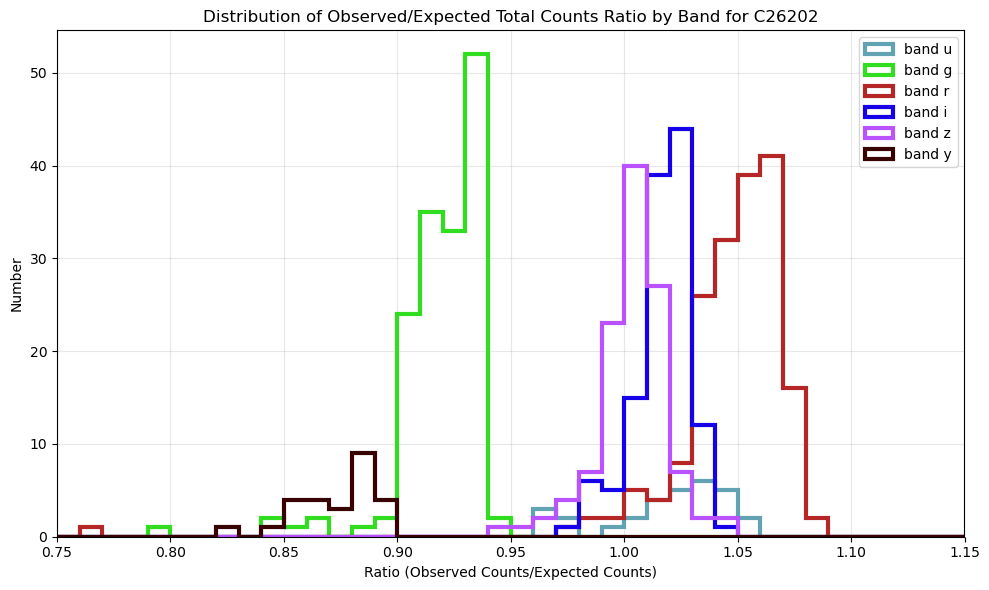

In [59]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level
linewidth = 3 # linewidth for the step histogram lines 

# Define bins.  Here, we want to look around ratio=1.00+/-0.20 in steps of 0.01
#bins = np.arange(0.80, 1.20, 0.01)
bins = np.arange(0.00, 2.00, 0.01)

# Plot histogram for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:  # only plot if we have data for this band
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=colors[band],
        #        density=False)  # density=True normalizes the area
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=filter_colors[band],
        #        linestyle=filter_linestyles[band], 
        #        density=False)  # density=True normalizes the area
        plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
                label=f'band {band}', color=filter_colors[band],
                density=False)  # density=True normalizes the area


plt.xlabel('Ratio (Observed Counts/Expected Counts)')
plt.ylabel('Number')
plt.xlim([0.75, 1.15])
#plt.xlim([0.00, 2.00])

plot_title = """Distribution of Observed/Expected Total Counts Ratio by Band for %s""" % (star_name)
plt.title(plot_title)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



### 7.3 Print summary statistics for each band

In [56]:
# Based on code retrieved from Claude-3.5-Sonnet

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:
        print(f"\nBand {band} statistics:")
        print(f"N = {len(band_data)}")
        print(f"Mean = {band_data.mean():.3f}")
        print(f"Median = {band_data.median():.3f}")
        print(f"Std = {band_data.std():.3f}")


Band u statistics:
N = 30
Mean = 1.020
Median = 1.026
Std = 0.026

Band g statistics:
N = 165
Mean = 0.892
Median = 0.921
Std = 0.113

Band r statistics:
N = 188
Mean = 1.012
Median = 1.051
Std = 0.168

Band i statistics:
N = 123
Mean = 1.017
Median = 1.019
Std = 0.013

Band z statistics:
N = 116
Mean = 1.004
Median = 1.004
Std = 0.016

Band y statistics:
N = 26
Mean = 0.874
Median = 0.880
Std = 0.017


Let's output a nice table...

In [57]:
# Create empty lists to store the statistics
stats_data = []

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:
        stats_data.append({
            'band': band,
            'n_band': len(band_data),
            'Mean': f"{band_data.mean():.3f}",
            'Median': f"{band_data.median():.3f}",
            'Std': f"{band_data.std():.3f}"
        })
    else:
        stats_data.append({
            'band': band,
            'n_band': 0,
            'Mean': 'N/A',
            'Median': 'N/A',
            'Std': 'N/A'
        })

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Display the table
display(stats_df)
#print(stats_df.to_string(index=False))

,band,n_band,Mean,Median,Std
0,u,30,1.020,1.026,0.026
1,g,165,0.892,0.921,0.113
2,r,188,1.012,1.051,0.168
3,i,123,1.017,1.019,0.013
4,z,116,1.004,1.004,0.016
5,y,26,0.874,0.880,0.017


**Let's stop here for now:**

In [58]:
print("Stopping here...")
raise StopExecution

Stopping here...


## 7. Sandbox

In [ ]:
# Check header of an ISR-corrected exposure image
icExp = butler.get('icExp', dataId=dataId)
icExp_info = icExp.getInfo()
print(icExp_info.getMetadata())
print(dataId)

In [ ]:
# From Lynne Jones...

# Read the file 
seddata = fits.getdata(sedfile)
# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)

sed = pt.Sed(wavelen=wavelen, flambda=flambda)


# exposure time and gain -- gain=1 -> e- counts
phot_params = pt.PhotometricParameters(exptime=30, gain=1, nexp=1)

mags = {}
counts = {}
counts_100k = {}
for f in 'ugrizy':
    mags[f] = sed.calc_mag(system[f])
    counts[f] = sed.calc_adu(system[f], phot_params)
    counts_100k[f] = counts[f]/100000

#pd.DataFrame([mags, counts, counts_100k], index=['AB mag', 'total counts', 'counts(100k)'])
for f in 'ugrizy':
    print(f, mags[f], counts[f], counts_100k[f])

In [ ]:
#fgcm_stars = butler.get("fgcm_Cycle5_StandardStars", collections=["u/erykoff/LSSTComCam/DM-47919/highlat/build4/run3"]).asAstropy()

In [ ]:
#fgcm_stars

In [ ]:
#fgcm_stars.write('fgcm_stars.ecsv')

In [ ]:
#from astropy.table import Table
#df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
#df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)

In [ ]:
#df_bad_visits

In [ ]:
#best_df[best_df['band'] == band]

In [ ]:
#for colname in best_df.columns:
#    print(colname)

In [ ]:
#best_df['detector'].unique()

In [ ]:
#best_df['id'].unique()

In [ ]:
#best_df[best_df['band']=='u'].plot('visit','ratio_obs_exp', kind='scatter')

In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['visit'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Visit')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['detector'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('detector')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['airmass'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Airmass')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
best_df['visit']

In [ ]:
df_sci

In [ ]:
merged_df = pd.merge(best_df, df_sci, left_on='visit', right_on='id', how='left')
merged_df

In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['airmass_y'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Airmass')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()


In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['mjd'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('MJD')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()


In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
#for band in ['u', 'g', 'r', 'i', 'z', 'y']:
for band in ['u']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['expos'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('exposure time [sec]')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()
